In [0]:
%load_ext autoreload
%autoreload 1

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

try:
  import tensorflow.compat.v2 as tf
except Exception:
  pass

tf.enable_v2_behavior()

print(tf.__version__)
#Connect to our own Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

#Go on the DL project folder
%cd "/content/gdrive/My Drive/NLP_Project/"
!ls


In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
import re
from string import punctuation
import matplotlib.pyplot as plt
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
import utils_cleaning as cl

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
df_train = pd.read_csv("data/train.csv")

In [5]:
train_question1 = []
cl.process_questions(train_question1, df_train.question1, 'train_question1', df_train)

train_question2 = []
cl.process_questions(train_question2, df_train.question2, 'train_question2', df_train)


train_question1 is 24.7% complete.
train_question1 is 49.5% complete.
train_question1 is 74.2% complete.
train_question1 is 98.9% complete.
train_question2 is 24.7% complete.
train_question2 is 49.5% complete.
train_question2 is 74.2% complete.
train_question2 is 98.9% complete.


In [6]:
#Load word2vec embeddings
from gensim.models import KeyedVectors
fname = 'embedding/GoogleNews-vectors-negative300.bin'

#saved in a binary format to save space
w2v_model = KeyedVectors.load_word2vec_format(fname, binary = True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
#{'a word' : vector of 300 } example : {'hello' : [0.034, ... , -0.045],...,'raised' : [0.05, 0.004,..., -0.22]}
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
max_seq_length = 50

vocabulary = dict()
inv_voc = ['forPad']  # '<unk>' acts as a placeholder for the zero vector embedding

qs = pd.DataFrame({'q1': train_question1, 'q2': train_question2})
qs_cols = ['q1', 'q2']

In [9]:
# Iterate through the text of both questions of each pair
for index, row in tqdm(qs.iterrows()):
    for qst in qs_cols:
        q2n = []  # q2n -> numerical vector representation of each question
        for word in row[qst]:
            # Check for stopwords who do not have a word2vec mapping and ignore them
            if word not in w2v_model.vocab:
                continue
            if word not in vocabulary:
                vocabulary[word] = len(inv_voc)
                q2n.append(len(inv_voc))
                inv_voc.append(word)
            else:
                q2n.append(vocabulary[word])

        # Replace questions with equivalent numerical vector/ word-indices
        qs.at[index, qst]=q2n
    

# Prepare embedding layer
embedding_dim = 300
embeddings = np.random.randn(len(vocabulary)+1, embedding_dim) # Embedding matrix
embeddings[0] = 0 #ignore the zero padding at the beginning of the sequence


404290it [01:02, 6419.66it/s]


In [10]:
# Build the embedding matrix
for word, index in tqdm(vocabulary.items()):
    if word in w2v_model.vocab:
        embeddings[index] = w2v[word]


del w2v_model, w2v

100%|██████████| 35/35 [00:00<00:00, 7980.90it/s]


In [11]:
import itertools
              
# Train-validation split
X = qs[qs_cols]
y = df_train['is_duplicate']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, random_state = 102)

# Preparing train and validation feature-sets
X_train = {'left': X_train.q1, 'right': X_train.q2}
X_val = {'left': X_val.q1, 'right': X_val.q2}

# Preparing target labels
y_train = y_train.values
y_val = y_val.values


## Importing required keras libraries
import keras
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM, Embedding, Input, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K


# Truncate and pad input sequences
for dataset, side in itertools.product([X_train, X_val], ['left', 'right']):
    dataset[side] = sequence.pad_sequences(dataset[side], maxlen=max_seq_length)

Using TensorFlow backend.


In [12]:
def exp_neg_manhattan_dist(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# Model variables
n_hidden = 35
batch_size = 64

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], 
                            input_length=max_seq_length, trainable=False)

left_input = Input(shape=(max_seq_length,), dtype='int32', name = 'input_1')
embed_seq_left = embedding_layer(left_input)

right_input = Input(shape=(max_seq_length,), dtype='int32', name = 'input_2')
embed_seq_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
lstm_layer  = LSTM(n_hidden, activation = 'relu', name = 'shared_lstm')

left_output = lstm_layer(embed_seq_left)
right_output = lstm_layer(embed_seq_right)

# Manhattan distance
custom_dist = Lambda(function=lambda x: exp_neg_manhattan_dist(x[0], x[1]), 
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Combine all of the above in a Model
model = Model([left_input, right_input], [custom_dist])

model.compile(loss='mean_squared_error', optimizer= 'adam', metrics=['accuracy'])

# Start training
model_save = ModelCheckpoint("model_w2c_6.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor="val_accuracy",patience=2)

callbacks_list = [model_save,earlyStopping]
history = model.fit([X_train['left'], X_train['right']], y_train, batch_size=batch_size, epochs=7,
                            validation_data=([X_val['left'], X_val['right']], y_val),callbacks=callbacks_list)


Train on 343646 samples, validate on 60644 samples
Epoch 1/7
343646/343646 [==============================] - 919s 3ms/step - loss: 0.1932 - accuracy: 0.7035 - val_loss: 0.1849 - val_accuracy: 0.7170

Epoch 00001: val_accuracy improved from -inf to 0.71699, saving model to model_w2c_6.h5
Epoch 2/7
343646/343646 [==============================] - 921s 3ms/step - loss: 0.1826 - accuracy: 0.7252 - val_loss: 0.1813 - val_accuracy: 0.7276

Epoch 00002: val_accuracy improved from 0.71699 to 0.72759, saving model to model_w2c_6.h5
Epoch 3/7
343646/343646 [==============================] - 905s 3ms/step - loss: 0.1788 - accuracy: 0.7325 - val_loss: 0.1776 - val_accuracy: 0.7354

Epoch 00003: val_accuracy improved from 0.72759 to 0.73536, saving model to model_w2c_6.h5
Epoch 4/7
343646/343646 [==============================] - 917s 3ms/step - loss: 0.1761 - accuracy: 0.7385 - val_loss: 0.1749 - val_accuracy: 0.7402

Epoch 00004: val_accuracy improved from 0.73536 to 0.74019, saving model to mod

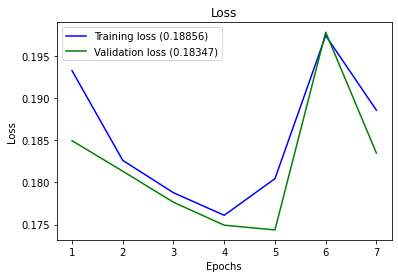

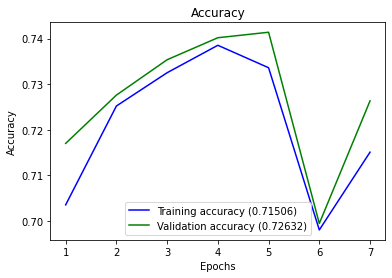

In [24]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [0]:
model.load_weights("model_w2c_6.h5")

preds = model.predict([X_val['left'], X_val['right']])
y_pred = [1 if x > 0.5 else 0 for x in preds] 
accuracy = (y_pred == y_val).sum()/len(y_val)

In [22]:
thresholds = []
for thresh in np.arange(0.1, 0.95, 0.01):
    thresh = np.round(thresh, 3)
    y_pred = [1 if x > thresh else 0 for x in preds] 
    accuracy = (y_pred == y_val).sum()/len(y_val)
    thresholds.append([thresh, accuracy])
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
best_acc = thresholds[0][1]
print("Best threshold: ", best_thresh,", best accuracy: ",best_acc)

Best threshold:  0.46 , best accuracy:  0.7444264890178748


In [23]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if x > best_thresh else 0 for x in preds] 

cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2 * (precision * recall)/(precision+ recall)

nb_duplicate = sum(y_val)/len(y_val)

print("Accuracy :",best_acc)
print("recall :",recall)
print("precision :",precision)
print("f1_Score :",f1_score)
print("Pourcentage de questions similaires :",nb_duplicate)

Accuracy : 0.7444264890178748
recall : 0.5934944819266342
precision : 0.674812030075188
f1_Score : 0.6315464162605492
Pourcentage de questions similaires : 0.36905547127498184
